In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import dask.dataframe as dd

# Plotting defaults
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = (12,8)

import matplotlib.pyplot as plt
import seaborn as sns

import gc 
import os
from collections import Counter

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [2]:
# Use the custom css
from IPython.core.display import HTML

def set_css_style(css_file_path):
   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)
# set_css_style('custom.css')

In [10]:
cd D:\Sunil\Professional\DataScience\DataIncubator\Capstone Project\iot_23_datasets_small\IoTScenarios\data

D:\Sunil\Professional\DataScience\DataIncubator\Capstone Project\iot_23_datasets_small\IoTScenarios\data


In [5]:
CONSOLIDATED_FILE_PATH = "consolidated.csv"

## <h1> Loading and basic data cleanup </h1>

##### Helper Functions

In [6]:
# Convert all the log files to individual files and one single csv and place them in a data folder 

def convert_log_to_csv(consolidated = False):
    
    if not os.path.exists('data'):
        os.makedirs('data')

    header = ','.join(header_list)

    input_folder = os.getcwd()
    output_folder = os.path.join(input_folder,'data')
    input_path = Path(input_folder)
    
    if (consolidated):
        cons_file_name = CONSOLIDATED_FILE_PATH
        cons_output_file = os.path.join(output_folder,cons_file_name)

    with open(cons_output_file, 'w') as consfile:
        if (consolidated):
            consfile.write(header+"\n")
        for p in input_path.rglob("*.log.labeled"):
            if p.is_file():
                input_file = p
                sep_file_name = os.path.basename(p.parent)+'.csv'
                sep_file_name = '{}.csv'.format(str(os.path.basename(p.parent)))
                sep_output_file = os.path.join(output_folder,sep_file_name)
                with open(input_file) as infile:
                    with open(sep_output_file, 'w') as sepfile:
                        sepfile.write(header+"\n")
                        for line in infile:
                            if not line.startswith("#"):
                                line = ','.join(line.split())
                                if (consolidated):
                                    consfile.write(line+"\n")
                                sepfile.write(line+"\n")
        print('File converted : ',sep_output_file)
    print('Consolidated data file : ',cons_output_file)
    print (f'Exact number of rows in consolidated file: {find_nrows(CONSOLIDATED_FILE_PATH)}')    

In [6]:
# Check memory usage in dataframe
def check_mem(data):
    if isinstance(data, pd.DataFrame):
        MB = round(data.memory_usage(deep=True).sum() / 1024**2,2)
        return MB
    return round(data.memory_usage(deep=True) / 1024**2,2)

In [7]:
# Find number of rows in a file
def find_nrows(file_path):
    with open(file_path) as file:
        n_rows = len(file.readlines())
    return n_rows

In [8]:
# Convert columns to category type
def convert_columns_to_category(df, columns):
    print("Converting columns to category : ")
    for col in columns:
        print("Column: ", col.ljust(15), "size: ", check_mem(df[col]), end="\t")
        df[col] = df[col].astype("category")
        print("->\t", check_mem(df[col]))

In [9]:
# Plot feature importance
def plot_feature_imp(feature_imp):
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

In [11]:
# Loading and perform basic clean of dataset and return dataframe
def load_dataset(data_files,verbose=True):
    
    # Make a list of dataframes
    dataframes = [pd.read_csv(file) for file in data_files]
    
    # Concatenate all the dataframes into one
    df = pd.concat(dataframes, ignore_index=True)
    
    # print shape of the dataframe
    print('Dataframe Rows : {:d}, Columns : {:d}'.format(df.shape[0],df.shape[1]))
    
    start_mem = check_mem(df)
    print('Mem. usage before clean-up : {:.2f} Mb'.format(start_mem))
    
    # Dropping some zero-variance and irrelevant columns     
    df.drop(columns = ['timestamp','uid','id.orig_h','id.resp_h','local_orig','local_resp','service','missed_bytes','tunnel_parents'], axis=1, inplace=True)
    
    # Replacing the orig_bytes & resp_bytes with '-' as 0     
    try:
        df.orig_bytes[df.orig_bytes == '-'] = 0
    except Exception as e:
        pass
    
    try:
        df.resp_bytes[df.resp_bytes == '-'] = 0
    except Exception as e:
        pass

     # Rename some columns     
    df.rename(columns={'id.orig_p': 'orig_port', 'id.resp_p': 'resp_port'}, inplace=True)    
    
    # Downcast columns to save on dataframe memory usage     
    numeric_cols = ['orig_bytes','resp_bytes','orig_port','resp_port','orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col],downcast='integer')
    
    # Set the invalid string to NaN, and downcast the duration column     
    df['duration'] = pd.to_numeric(df['duration'],downcast='float',errors='coerce').fillna(0)
    
    # Change the label 'benign' to 'Benign'     
    df['label'] = df['label'].replace(['benign'],'Benign')
    
    # Merging 2 columns (label and detailed-label) into one for later use    
    df['combined-label'] = np.where(df['label'] == 'Malicious', df['detailed-label'],df['label'])
    
    # Dropping 'detailed-label' column
    df.drop('detailed-label',axis=1, inplace=True)
    
    # Converting the object cols to category
    convert_columns_to_category(df, columns=['proto','conn_state','history','label','combined-label'])
    
    # Replacing other '-' symbol with None
    df.replace('-','None',inplace=True)
    
    # Check memory usage after clean-up 
    end_mem = check_mem(df)

    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction) after clean-up'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df    

##### Pre-processing CSV files after conversion

In [12]:
# CSV files to be processed

data_files = [
    'CTU-Honeypot-Capture-7-1.csv',
    'CTU-IoT-Malware-Capture-44-1.csv',
    'CTU-IoT-Malware-Capture-9-1.csv',
    'CTU-Honeypot-Capture-4-1.csv',
    'CTU-Honeypot-Capture-5-1.csv',
    'CTU-IoT-Malware-Capture-20-1.csv',
    'CTU-IoT-Malware-Capture-21-1.csv',
    'CTU-IoT-Malware-Capture-42-1.csv',
    'CTU-IoT-Malware-Capture-8-1.csv',
    'CTU-IoT-Malware-Capture-34-1.csv',
    'CTU-IoT-Malware-Capture-3-1.csv',
    'CTU-IoT-Malware-Capture-1-1.csv',
    'CTU-IoT-Malware-Capture-60-1.csv',
    'CTU-IoT-Malware-Capture-48-1.csv'
]

In [13]:
%%time
dfm = load_dataset(data_files)

Dataframe Rows : 14565172, Columns : 23
Mem. usage before clean-up : 13760.42 Mb
Converting columns to category : 
Column:  proto           size:  833.45	->	 13.89
Column:  conn_state      size:  823.01	->	 13.89
Column:  history         size:  805.8	->	 27.81
Column:  label           size:  915.28	->	 13.89
Column:  combined-label  size:  1057.17	->	 13.89
Mem. usage decreased to 583.43 Mb (95.8% reduction) after clean-up
Wall time: 1min 56s


##### Mem. usage decreased from 13760.42 Mb to 583.43 Mb (95.8% reduction) after clean-up

In [137]:
# Saving the dataframe to csv for further loading
dfm.to_csv('data.csv',index=False)

In [138]:
# Saving objects as pickle-files for faster loading
dfm.to_pickle("data.pkl")

In [17]:
# size of csv and pickle file
print("data.csv: {} MB".format(round(os.stat('data.csv').st_size * 1e-6,2)))
print("data.pkl: {} MB".format(round(os.stat('data.pkl').st_size * 1e-6,2)))

data.csv: 989.86 MB
data.pkl: 611.74 MB


## EDA/Data Exploration

##### Helper Functions

In [27]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    
    explode = tuple([0.1] * len(target_stats))
    
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes),textprops={'fontsize': 14})
    ax.axis('equal')

In [28]:
def plot_bar(y,title='',xlabel=''):
    fig = plt.figure(figsize = (10, 5))
    labels = y.value_counts(normalize=True).index.tolist()
    sizes = y.value_counts().tolist()
    labels_avg_size = np.mean(sizes)
    g = sns.barplot(sizes,labels,alpha=0.8)
    for i, v in enumerate(sizes):
        g.text(v+1, i, str(int(v)),fontsize = 14) 
    plt.axvline(labels_avg_size) 
    plt.yticks(fontsize=14) 
    plt.xticks(fontsize=14)
    plt.show()

##### A glance on overall data composition

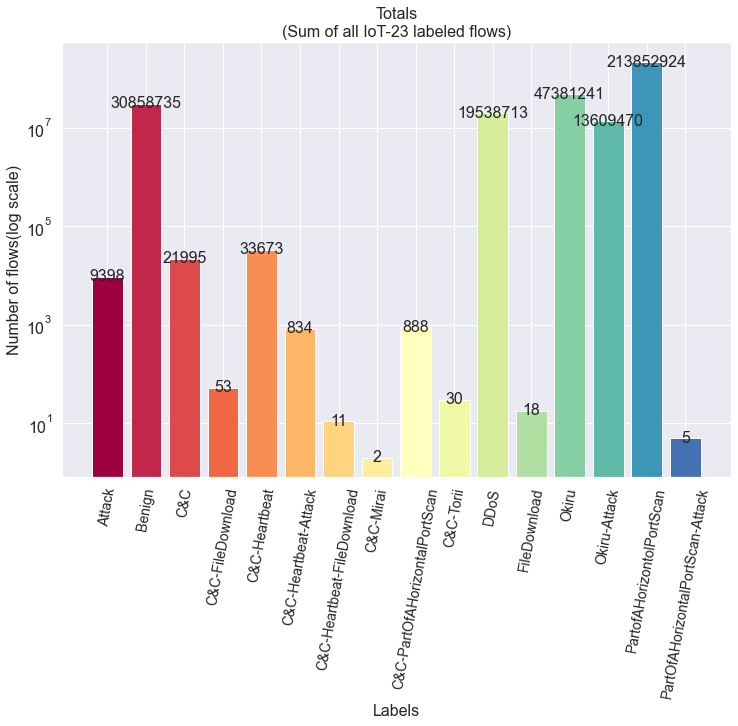

In [36]:
sns.set_theme(style="darkgrid")

X = ['Attack','Benign','C&C','C&C-FileDownload','C&C-Heartbeat','C&C-Heartbeat-Attack',
     'C&C-Heartbeat-FileDownload','C&C-Mirai','C&C-PartOfAHorizontalPortScan','C&C-Torii','DDoS','FileDownload',
     'Okiru','Okiru-Attack','PartofAHorizontolPortScan','PartOfAHorizontalPortScan-Attack']

Y = [9398,30858735,21995,53,33673,834,11,2,888,30,19538713,18,47381241,13609470,213852924,5]

colors = [plt.cm.Spectral(i/float(len(Y))) for i in range(len(Y))]
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()
ax.grid(True)

ax.bar(X, Y,color=colors,width=0.8)

for i, (k, v) in enumerate(zip(X,Y)):
    ax.text(k, 
            v, 
            v, 
            fontsize = 16, 
            horizontalalignment = 'center', 
            verticalalignment = 'center'
           )

ax.tick_params(axis = 'x', labelrotation = 80, labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_yscale('log')
ax.set_xlabel('Labels',fontsize=16)
ax.set_ylabel('Number of flows(log scale)', fontsize=16)
ax.set_title("Totals\n(Sum of all IoT-23 labeled flows)", fontsize = 16);

plt.show()

##### Continue on exploring the files initially selected and cleaned for data exploration

In [30]:
# Reading pickle directly from file for processing
df = pd.read_pickle('data.pkl')

In [31]:
set(df['combined-label'])

{'Attack',
 'Benign',
 'C&C',
 'C&C-FileDownload',
 'C&C-HeartBeat',
 'C&C-HeartBeat-Attack',
 'C&C-HeartBeat-FileDownload',
 'C&C-PartOfAHorizontalPortScan',
 'C&C-Torii',
 'DDoS',
 'FileDownload',
 'PartOfAHorizontalPortScan'}

##### Basic stats

In [62]:
stats = []

for col in df.columns:
    stats.append((col, df[col].dtype, df[col].nunique(),df[col].mode()[0], df[col].value_counts(normalize=True).values[0] * 100))
    
stats_df = pd.DataFrame(stats, columns=['Feature', "type", 'Unique_values', 'biggest category', '% of values in biggest category'])

stats_df.sort_values('% of values in biggest category', ascending=False)

,Feature,type,Unique_values,biggest category,% of values in biggest category
5,resp_bytes,int32,911,0,99.751194
10,resp_pkts,int32,126,0,99.635967
11,resp_ip_bytes,int32,1917,0,99.635967
4,orig_bytes,int32,758,0,99.628477
2,proto,category,3,tcp,96.813735
12,label,category,2,Malicious,96.431728
6,conn_state,category,13,S0,74.791111
3,duration,float32,93810,0.0,74.422444
7,history,category,268,S,71.901472
13,combined-label,category,12,PartOfAHorizontalPortScan,71.588911


##### Benign vs Malicious class distribution

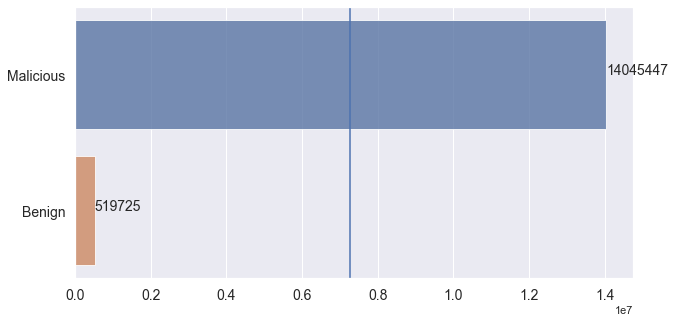

In [38]:
plot_bar(df['label'],title='Overall class distribution',xlabel='Size')

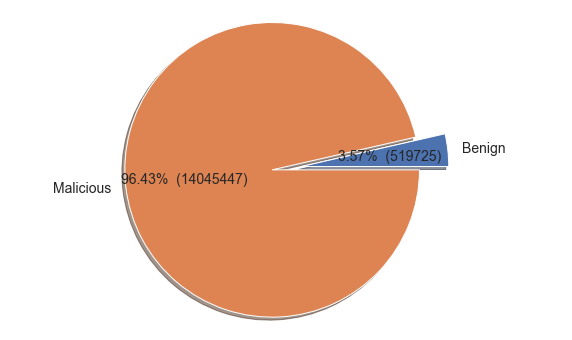

In [39]:
plot_pie(df['label'])

In [40]:
label_ratio = df.label.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
label_ratio

Malicious    96.43%
Benign        3.57%
Name: label, dtype: object

##### Data seem highly imbalanced. I would expect 'Benign' data to be more in composition than 'Malicious' generally. let's looks at the malware families 

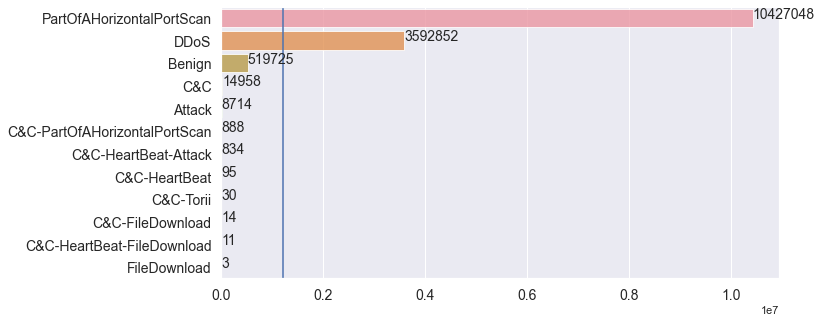

In [41]:
plot_bar(df['combined-label'],title='Class and family distribution in analysed dataset', xlabel='Size')

##### From the above graph, it is clear, there is high imbalance in the Malware family data as well.

In [42]:
combined_label_ratio = df['combined-label'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
combined_label_ratio

PartOfAHorizontalPortScan        71.59%
DDoS                             24.67%
Benign                            3.57%
C&C                                0.1%
Attack                            0.06%
C&C-PartOfAHorizontalPortScan     0.01%
C&C-HeartBeat-Attack              0.01%
C&C-HeartBeat                      0.0%
C&C-Torii                          0.0%
C&C-FileDownload                   0.0%
C&C-HeartBeat-FileDownload         0.0%
FileDownload                       0.0%
Name: combined-label, dtype: object

In [43]:
# Extracting the Dataframe separately for each class
dfm = df[df['label']=='Malicious']
dfb = df[df['label']=='Benign']

# Looking at individual features 

#### Set of values that appears most often across the Malicious data

In [46]:
dfm.mode()

,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,combined-label
0,65279,23,tcp,0.0,0,0,S0,S,1,40,0,0,Malicious,PartOfAHorizontalPortScan


#### Set of values that appears most often across the Benign data

In [47]:
dfb.mode()

,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,combined-label
0,43763,123,udp,0.0,0,0,S0,D,1,40,0,0,Benign,Benign


#### Traffic - types (Protocol) - Looks majorly TCP traffic

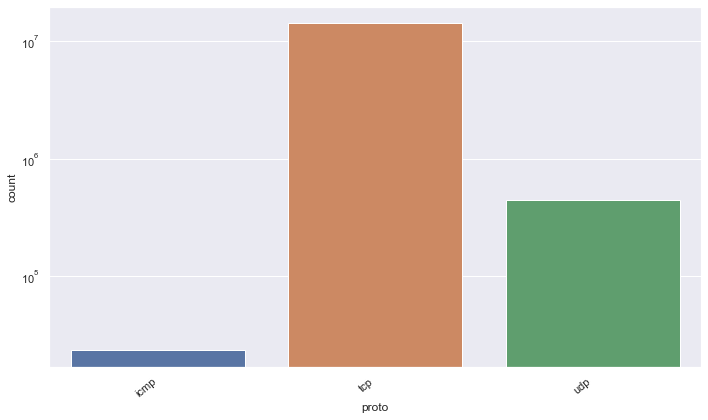

In [48]:
countplot("proto",df)

#### Top 10 ports used by the responding endpoint. Telnet(23) is the most port used.

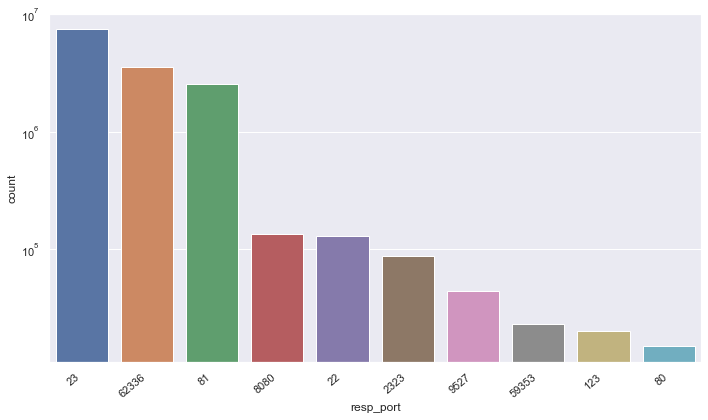

In [49]:
df_resp_port = df['resp_port']
order =  df_resp_port.value_counts().iloc[:10].index
countplot(df_resp_port,df,order=order)

#### Telnet(23) is mostly used for HorizontolPortScan(scan against a group of IPs for a single port)

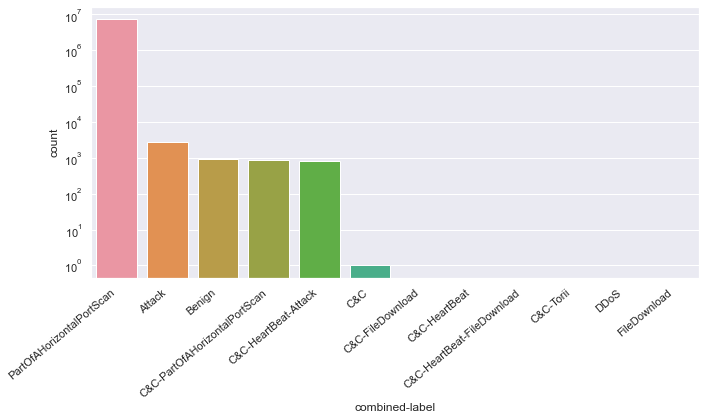

In [50]:
port_23_comb = df[df['resp_port']==23]['combined-label']
order = port_23_comb.value_counts().index
countplot(port_23_comb,df,order=order)

#### Responding endpoint’s TCP/UDP port (or ICMP code) categorised by protocol

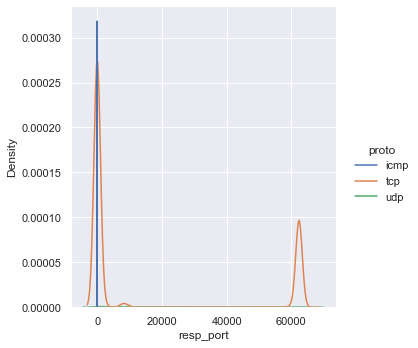

In [51]:
sns.displot(df, x="resp_port", hue="proto", kind="kde")

#### Responding endpoint’s TCP/UDP port (or ICMP code) categorised by class

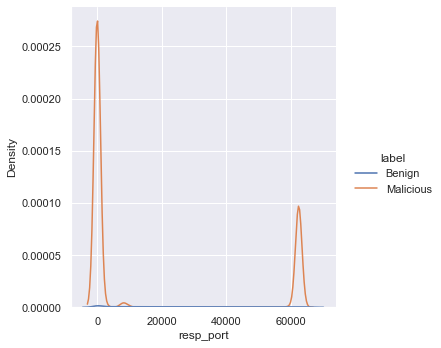

In [52]:
sns.displot(df, x="resp_port", hue="label", kind="kde")

#### Responding endpoint’s TCP/UDP port (or ICMP code) for Benign class

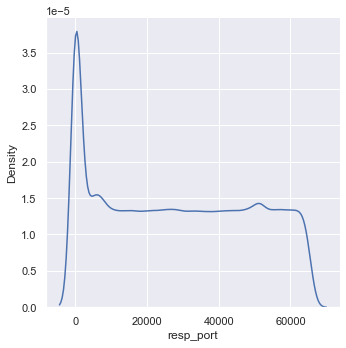

In [53]:
sns.displot(dfb, x="resp_port", kind="kde")

#### Top 10 ports used by the originating endpoint.

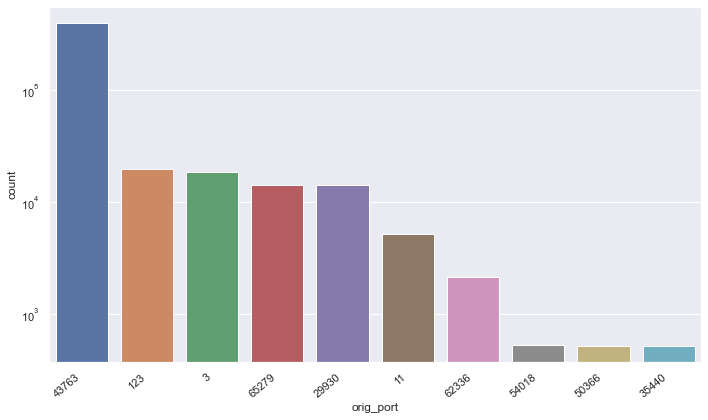

In [54]:
order = df['orig_port'].value_counts().iloc[:10].index
countplot(df['orig_port'],df,order=order)

#### Distribution of originating endpoint’s TCP/UDP port (or ICMP code) categorised by protocol

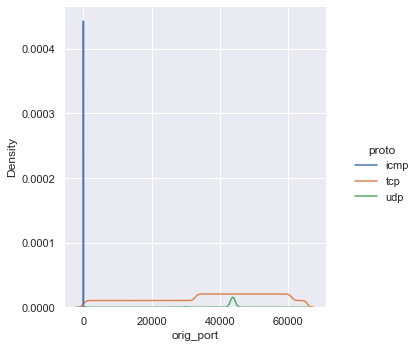

In [55]:
sns.displot(df, x="orig_port", hue="proto", kind="kde")

#### Distribution of originating endpoint’s TCP/UDP port (or ICMP code) categorised by class

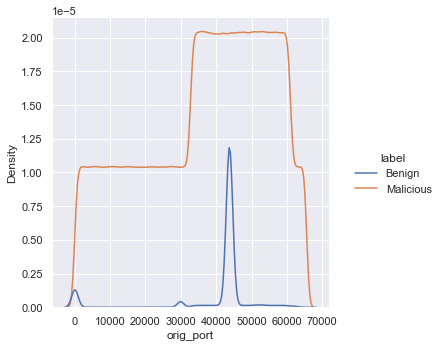

In [56]:
sns.displot(df, x="orig_port", hue="label", kind="kde")

#### Responder payload bytes

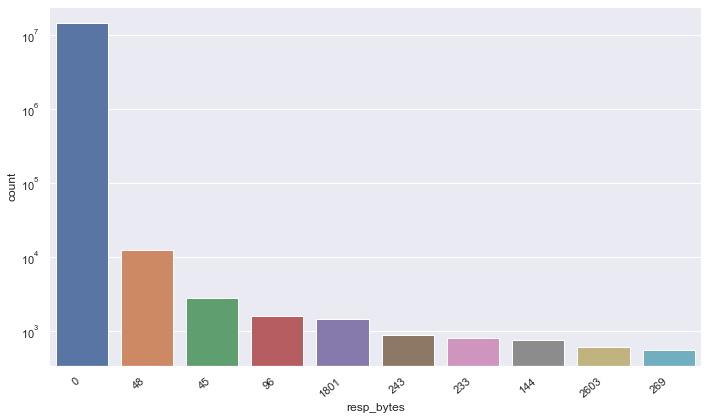

In [57]:
order = df['resp_bytes'].value_counts().iloc[:10].index
countplot(df['resp_bytes'],df,order=order)

#### Connection States

In [63]:
# ======conn_state=====: 
# Possible conn_state values:

# S0: Connection attempt seen, no reply.
# S1: Connection established, not terminated.
# SF: Normal establishment and termination. Note that this is the same symbol as for state S1. You can tell the two apart 
# because for S1 there will not be any byte counts in the summary, while for SF there will be.
# REJ: Connection attempt rejected.
# S2: Connection established and close attempt by originator seen (but no reply from responder).
# S3: Connection established and close attempt by responder seen (but no reply from originator).
# RSTO: Connection established, originator aborted (sent a RST).
# RSTR: Responder sent a RST.
# RSTOS0: Originator sent a SYN followed by a RST, we never saw a SYN-ACK from the responder.
# RSTRH: Responder sent a SYN ACK followed by a RST, we never saw a SYN from the (purported) originator.
# SH: Originator sent a SYN followed by a FIN, we never saw a SYN ACK from the responder (hence the connection was “half” open)
# SHR: Responder sent a SYN ACK followed by a FIN, we never saw a SYN from the originator.
# OTH: No SYN seen, just midstream traffic (a “partial connection” that was not later closed).

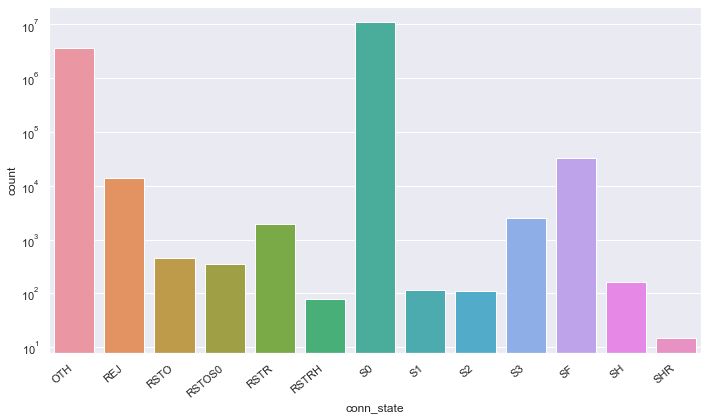

In [64]:
countplot("conn_state",df)

#### History

In [65]:
# ======history=====: 

# If the event comes from the originator, the letter is in upper-case; 
# if it comes from the responder, it’s in lower-case. 

# The ‘a’, ‘d’, ‘i’ and ‘q’ flags are recorded a maximum of one time in either direction regardless of how many are actually 
# seen.
# ‘f’, ‘h’, ‘r’ and ‘s’ can be recorded multiple times for either direction if the associated sequence number differs from the
# last-seen packet of the same flag type. 
# ‘c’, ‘g’, ‘t’ and ‘w’ are recorded in a logarithmic fashion: the second instance
#  represents that the event was seen (at least) 10 times; the third instance, 100 times; etc.

# Letter	Meaning
# s : a SYN w/o the ACK bit set
# h : a SYN+ACK (“handshake”)
# a : a pure ACK
# d : packet with payload (“data”)
# f : packet with FIN bit set
# r : packet with RST bit set
# c : packet with a bad checksum (applies to UDP too)
# g : a content gap
# t : packet with retransmitted payload
# w : packet with a zero window advertisement
# i : inconsistent packet (e.g. FIN+RST bits set)
# q : multi-flag packet (SYN+FIN or SYN+RST bits set)
# ^ : connection direction was flipped by Zeek’s heuristic

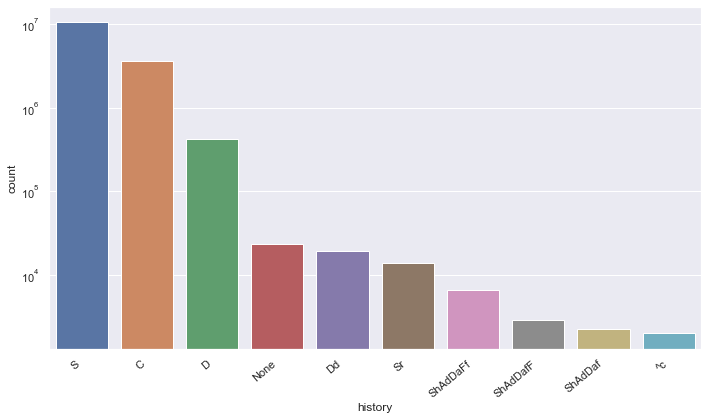

In [66]:
order=pd.value_counts(df['history']).iloc[:10].index
countplot(df['history'], df,order=order )

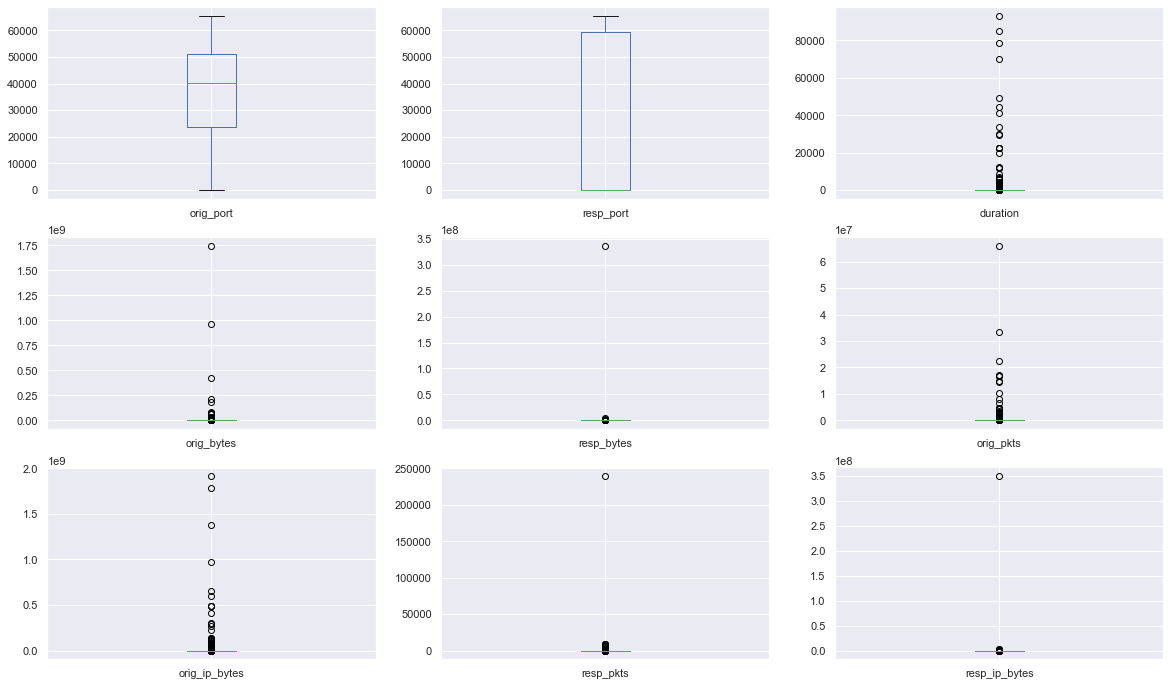

In [67]:
# box and whisker plots
df.plot(kind='box', subplots=True, layout=(3,3), figsize=(20,12))
plt.show()

### Looking individually at Malicious Family

### DDoS
This label indicates that a Distributed Denial of Service attack is being executed by the infected device. These traffic flows are detected as part of a DDoS attack because of the amount of flows directed to the same IP address.

Important features includes:
packet size
inter packet interval

In [68]:
port_map = {1:'TCPMUX',13:'DAYTIME',21: 'FTP',22: 'SSH',23: 'TELNET',25: 'SMTP',53: 'DNS',67: 'BOOTP',69: 'TFTP',80: 'HTTP',81: 'HTTP',8080: 'HTTP',123: 'NTP',137: 'NETBIOS-NS',138: 'NETBIOS-DGM',139: 'NETBIOS-SSN',143: 'IMAP',156: 'SQL-SERVER',389: 'LDAP',443: 'HTTPS',546: 'DHCP-CLIENT',547: 'DHCP-SERVER',995: 'POP3-SSL',993: 'IMAP-SSL',2323: 'TELNET',5353: 'DNS',6881: 'BIT-TORRENT',6889: 'BIT-TORRENT',8999: 'I2P',}

In [69]:
# 'DDoS'
ddos_df = df[df['combined-label']=='DDoS']
ddos_df.mode()

,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,combined-label
0,65279,62336,tcp,0.0,0,0,OTH,C,0,0,0,0,Malicious,DDoS


In [70]:
ddos_df['conn_state'].value_counts()[:3]
# Most of the connection state observed is OTH: No SYN seen, just midstream traffic 
# (one example of this is a “partial connection” that was not later closed).

OTH    3592691
S0         161
REJ          0
Name: conn_state, dtype: int64

In [71]:
ddos_df['history'].value_counts()[:3]

C     3592643
S         133
^c         40
Name: history, dtype: int64

In [72]:
ddos_df.head()

,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,combined-label
358,38897,80,udp,300.802368,1744830458,0,S0,D,1305034,1781371410,0,0,Malicious,DDoS
6408191,65279,80,tcp,0.000000,0,0,OTH,C,0,0,0,0,Malicious,DDoS
6408192,65279,80,tcp,0.000000,0,0,OTH,C,0,0,0,0,Malicious,DDoS
6408193,65279,80,tcp,0.000000,0,0,OTH,C,0,0,0,0,Malicious,DDoS
6408194,65279,80,tcp,0.000000,0,0,OTH,C,0,0,0,0,Malicious,DDoS


In [73]:
ddos_df['orig_ip_bytes'].value_counts()[:3]

0         3592691
40            121
122760          2
Name: orig_ip_bytes, dtype: int64

In [74]:
# Looks like service field is not updated, Let's look at the ports
ddos_df['resp_port'].value_counts()[:3]

62336    3578391
80         14448
9307           6
Name: resp_port, dtype: int64

In [75]:
ddos_df['orig_port'].value_counts()[:3]

65279    14217
51146      107
10296      104
Name: orig_port, dtype: int64

In [76]:
ddos_df['proto'].value_counts()

# Based on the results, it looks like the connection were mostly tcp level (connection-oriented)

tcp     3592824
udp          28
icmp          0
Name: proto, dtype: int64

### Correlation Matrix

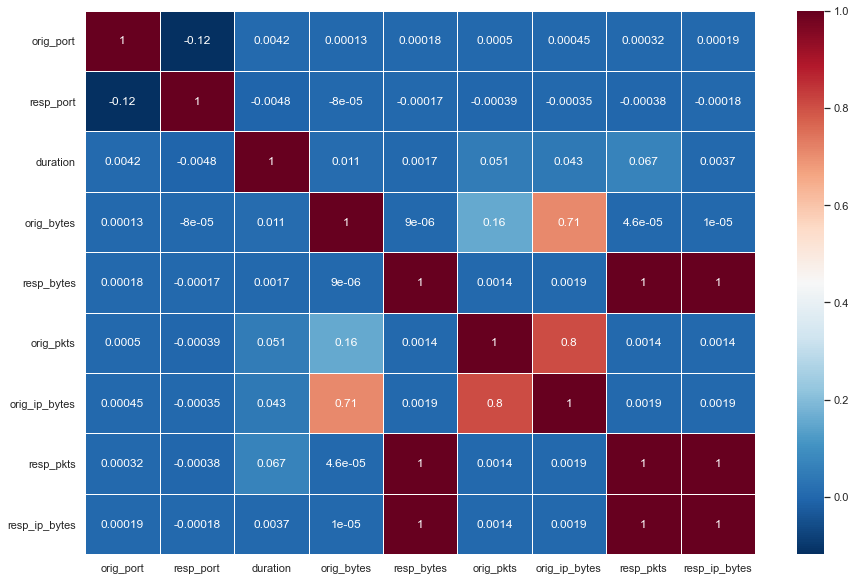

In [77]:
plt.figure(figsize=(15,10))
corr=df.corr()
sns.heatmap(corr, linewidths=.8, cmap='RdBu_r',annot=True)
plt.show()
fig.savefig('corr.png', dpi=100)

In [78]:
def get_feature_correlation(df, top_n=None, corr_method='spearman',
                            remove_duplicates=True, remove_self_correlations=True):
    corr_matrix_abs = df.corr(method=corr_method).abs()
    corr_matrix_abs_us = corr_matrix_abs.unstack()
    sorted_correlated_features = corr_matrix_abs_us \
        .sort_values(kind="quicksort", ascending=False) \
        .reset_index()

    if remove_self_correlations:
        sorted_correlated_features = sorted_correlated_features[
            (sorted_correlated_features.level_0 != sorted_correlated_features.level_1)
        ]

    if remove_duplicates:
        sorted_correlated_features = sorted_correlated_features.iloc[:-2:2]

    sorted_correlated_features.columns = ['Feature 1', 'Feature 2', 'Correlation (abs)']

    if top_n:
        return sorted_correlated_features[:top_n]

    return sorted_correlated_features

get_feature_correlation(df,top_n=10)

,Feature 1,Feature 2,Correlation (abs)
9,resp_ip_bytes,resp_pkts,1.000000
11,orig_pkts,orig_ip_bytes,0.985898
13,resp_ip_bytes,resp_bytes,0.826901
15,resp_bytes,resp_pkts,0.826556
17,orig_pkts,duration,0.819676
19,orig_bytes,resp_bytes,0.816371
21,orig_ip_bytes,duration,0.811272
23,resp_port,orig_pkts,0.783774
25,orig_ip_bytes,resp_port,0.770349
27,resp_ip_bytes,orig_bytes,0.708150


In [79]:
# From above some of the cols seem to have 99% of the values are same, and thus makes the data as highly imbalanced.

unbalanced_feature_rate_threshold = 0.9

filter_cols = list(df.columns)

for col in df.columns:
    
    # remove columns with high Unbalanced values rate
    unbalanced_rate = df[col].value_counts(normalize=True, dropna=False).values[0]
    
    if unbalanced_rate > unbalanced_feature_rate_threshold:
        filter_cols.remove(col)

filter_cols

['orig_port',
 'resp_port',
 'duration',
 'conn_state',
 'history',
 'orig_pkts',
 'orig_ip_bytes',
 'combined-label']

## Model Build

In [43]:
from numpy import mean
from numpy import std
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score,classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

##### Helper Functions

In [36]:
def countplot(col,data,log=True,title='',order=None):
    fig, ax = plt.subplots(figsize=(10,6))
    if order is not None:
         ax = sns.countplot(x=col, data=data,order=order)
    else:
        ax = sns.countplot(x=col, data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_title(title)
    if log:
        ax.set_yscale("log")
    plt.tight_layout()
    plt.show()

In [37]:
# Plot confusion matrix
def plot_confusion_matrix(matrix,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap="YlGnBu",
                          fmt="f"):
    # Get and reshape confusion matrix data
    
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(10,6))
    sns.set(font_scale=1.2)
    sns.heatmap(matrix, annot=True, annot_kws={'size':12},linewidths=0.2, fmt=fmt, cmap=cmap)

    # Add labels to the plot
    class_names = ['Benign','Malicious']
    
    tick_marks = np.arange(len(class_names))+0.5
    tick_marks2 = tick_marks
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks2, class_names)
           
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    plt.title(title)
    plt.show()

In [38]:
# ROC curve
def plot_roc(label=""):
    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, marker='.', label = label, linewidth = 2)
    # plot no skill roc curve
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(label)
    plt.legend()
    plt.show();

In [39]:
# ROC curve
def plot_roc_all_models(label=""):
    plt.figure(figsize=(16, 12))
    plt.plot(fpr_rf, tpr_rf, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_xgb, tpr_xgb, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_log, tpr_log, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_voting, tpr_voting, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr, tpr, marker='.', label = label, linewidth = 2)
    # plot no skill roc curve
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show();

In [40]:
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [98]:
def load_pkl(data_file,family=False):
    df = pd.read_pickle(data_file)
    df.drop_duplicates(inplace=True)
    
    le = LabelEncoder()
    
    df['conn_state'] = le.fit_transform(df['conn_state'])
    df['history'] = le.fit_transform(df['history'])
    df = pd.get_dummies(data=df,columns=['proto'])
    
    X = df.drop(['label', 'combined-label'], axis=1)
    
    if(family):
        y = df['combined-label']
    else:
        y = df['label']
    y = le.fit_transform(y)
    
    return X,y

In [99]:
X,y = load_pkl('data.pkl')
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

(2539409, 14) (2539409,) Counter({1: 2408722, 0: 130687})


# Class level(Benign and Malicious)

In [102]:
from sklearn.model_selection import train_test_split

# Split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

# Splitting the data in training and remaining dataset
# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, stratify=y, random_state=2)

# defining valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,stratify=y_rem, random_state=2)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(2031527, 14)
(2031527,)
(253941, 14)
(253941,)
(253941, 14)
(253941,)


(None, None)

In [155]:
test_data = X_valid
test_data['label'] = y_valid
# Saving the dataframe to csv for further test
test_data.to_csv('test_data.csv',index=False)
Counter(test_data['label'])

Counter({1: 240873, 0: 13068})

In [104]:
# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) # scaling should be fit on training data 
X_test_scaled = scaler.transform(X_test) # Only transform the test data

## Dummy classifier

In [105]:
# define the reference model
dummy = DummyClassifier(strategy='most_frequent')

# evaluate the model
scores = evaluate_model(X_train, y_train, dummy)

# summarize performance
print('Mean accuracy score: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean accuracy score: 0.949 (0.000)


As expected the accuracy is as per the distribution of the class(Malicious 96.4% and Benign 3.6%).
Let's run some other classifiers(without any hyperparameter tunning).

In [33]:
dummy.fit(X_train, y_train)
predicted = dummy.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     51973
           1       0.96      1.00      0.98   1404545

    accuracy                           0.96   1456518
   macro avg       0.48      0.50      0.49   1456518
weighted avg       0.93      0.96      0.95   1456518



As can be observed, even though the accuracy score is 0.964, still the F1 score is only 0

## Logistic Regression classifier (without class_weight and normalization)

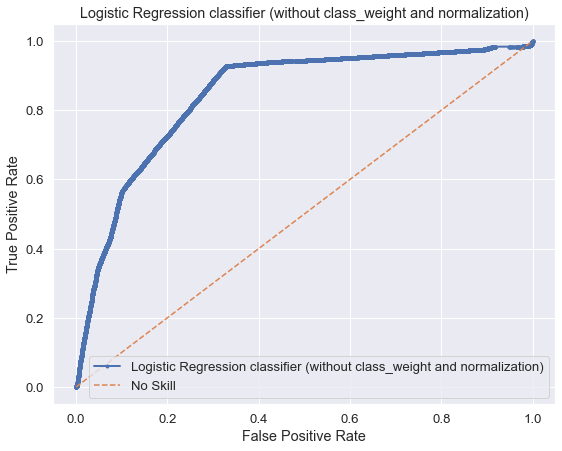

Wall time: 18.9 s


In [106]:
%%time
lr = LogisticRegression()
lr.fit(X_train, y_train)

# predict probabilities
yhat = lr.predict_proba(X_test)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, t = roc_curve(y_test, pos_probs)

# plot model roc curve
plot_roc("Logistic Regression classifier (without class_weight and normalization)")

In [107]:
predicted = lr.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.12      0.04      0.06     13069
           1       0.95      0.98      0.97    240872

    accuracy                           0.94    253941
   macro avg       0.53      0.51      0.51    253941
weighted avg       0.91      0.94      0.92    253941



As can be seen the F1-score for class 0 (benign) gets a very low score of 0.07. While the precision is still good (low False positive), but recall score is very low (0.03) which signifies high False negative.

## Logistic Regression classifier (with class_weight and without normalization)

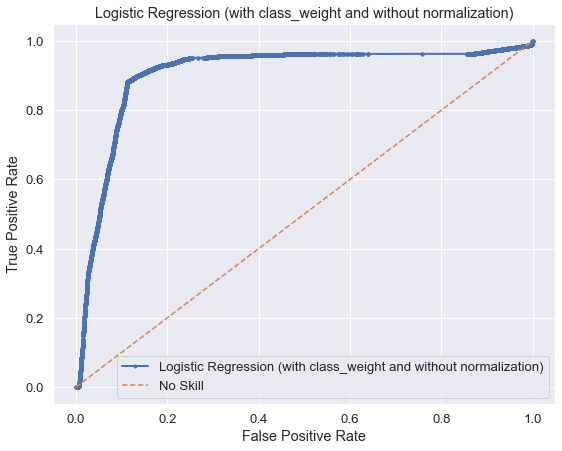

Wall time: 18.1 s


In [108]:
%%time
# Let's load the data obtained after using cost sensitive LR.
lr_balanced = LogisticRegression(solver='lbfgs',class_weight='balanced')
lr_balanced.fit(X_train, y_train)

# predict probabilities
yhat = lr_balanced.predict_proba(X_test)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)

# plot model roc curve
plot_roc("Logistic Regression (with class_weight and without normalization)")

In [109]:
predicted = lr_balanced.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.43      0.77      0.55     13069
           1       0.99      0.94      0.96    240872

    accuracy                           0.93    253941
   macro avg       0.71      0.86      0.76    253941
weighted avg       0.96      0.93      0.94    253941



After the class_weight='balanced', F1-score is increased to 0.19, which is attributed to high recall score, but still low precision score for class 0 (benign)

## Logistic Regression classifier (with SMOTE - oversampling the minority class and without normalization)

#### SMOTE

https://imbalanced-learn.org/stable/introduction.html

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In the resampling setting, there is a common pitfall that corresponds to resample the entire dataset before splitting it into a train and a test partitions. Note that it would be equivalent to resample the train and test partitions as well.

Such of a processing leads to two issues:

- the model will not be tested on a dataset with class distribution similar to the real use-case. Indeed, by resampling the entire dataset, both the training and testing set will be potentially balanced while the model should be tested on the natural imbalanced dataset to evaluate the potential bias of the model;

- the resampling procedure might use information about samples in the dataset to either generate or select some of the samples. Therefore, we might use information of samples which will be later used as testing samples which is the typical data leakage issue.

In [110]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(y_train)
print(counter)

# transform the dataset
oversample = SMOTE()

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

Counter({1: 1926977, 0: 104550})


In [111]:
counter = Counter(y_train_smote)
print(counter)

Counter({1: 1926977, 0: 1926977})


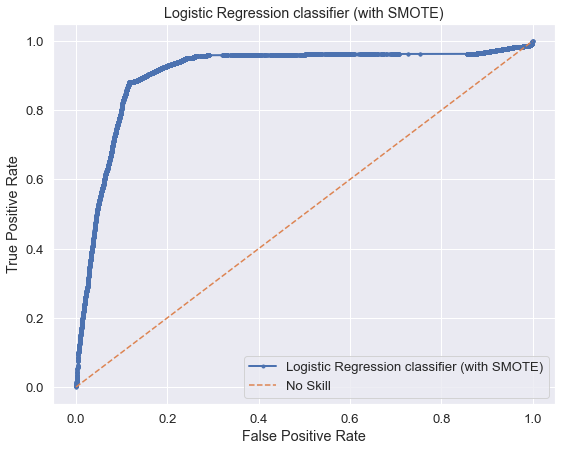

Wall time: 17.2 s


In [112]:
%%time
# Let's load the data obtained after using cost sensitive LR.
lr_smote = LogisticRegression(solver='lbfgs')
lr_smote.fit(X_train_smote, y_train_smote)

# predict probabilities
yhat = lr_smote.predict_proba(X_test)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)

# plot model roc curve
plot_roc("Logistic Regression classifier (with SMOTE)")

In [113]:
predicted = lr_smote.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.48      0.74      0.58     13069
           1       0.99      0.96      0.97    240872

    accuracy                           0.95    253941
   macro avg       0.73      0.85      0.78    253941
weighted avg       0.96      0.95      0.95    253941



Observations:
- F1 score(both precision and recall) is improved only slightly with SMOTE (oversampling the minority class), in comparison to class_weight = 'balanced'.

## Logistic Regression classifier (with class_weight and normalization)

#### Scaling/Normalization
Algorithms that fit a model that use a weighted sum of input variables are affected by difference in scales of the values in the data, such as linear regression, logistic regression, and artificial neural networks (deep learning).
Also, algorithms that use distance measures between examples are also affected, such as k-nearest neighbors and support vector machines. There are also algorithms that are unaffected by the scale of numerical input variables, most notably decision trees and ensembles of trees, like random forest.

In [114]:
%%time
lr_sb = LogisticRegression(solver='lbfgs',class_weight='balanced')

lr_sb.fit(X_train_scaled, y_train)

Wall time: 13.2 s


LogisticRegression(class_weight='balanced')

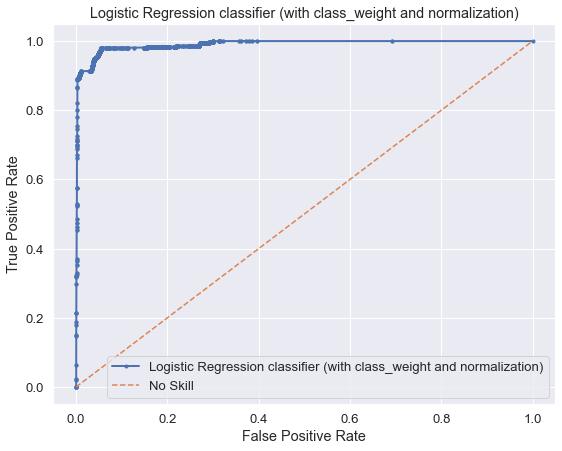

In [115]:
# predict probabilities
yhat = lr_sb.predict_proba(X_test_scaled)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)

# storing fpr,tpr and threshold for later
fpr_lr, tpr_lr, t_lr = fpr, tpr, t 

# plot model roc curve
plot_roc("Logistic Regression classifier (with class_weight and normalization)")

In [116]:
predicted = lr_sb.predict(X_test_scaled)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.92      0.81     13069
           1       1.00      0.98      0.99    240872

    accuracy                           0.98    253941
   macro avg       0.86      0.95      0.90    253941
weighted avg       0.98      0.98      0.98    253941



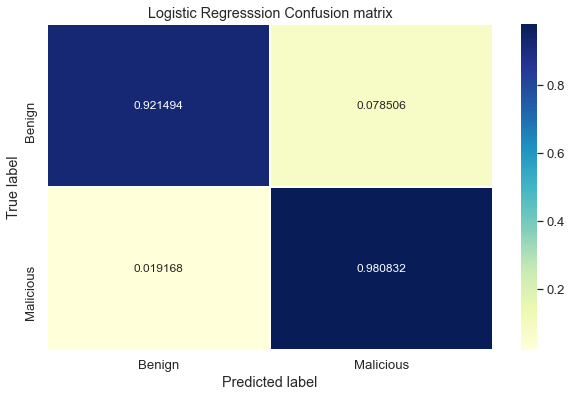

In [117]:
# Get and reshape confusion matrix data
import numpy as np
import seaborn as sns
matrix = confusion_matrix(y_test, predicted)
plot_confusion_matrix(matrix,title = 'Logistic Regresssion Confusion matrix')

In [118]:
coefs = pd.DataFrame(
    lr_sb.coef_.transpose(),
    columns=['Coefficients'], index=X.columns.tolist()
)
feature_imp = pd.Series(coefs['Coefficients']).sort_values(ascending=False)

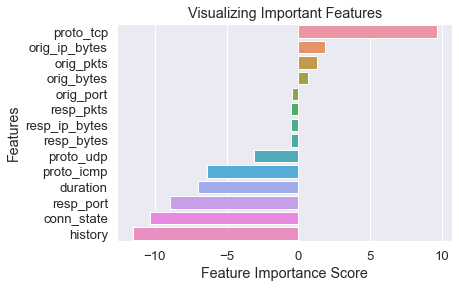

In [119]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

There is significant improvement observed after normalization/standardization. Let's check last with SMOTE as well.

## Logistic Regression classifier (with SMOTE and normalization)

Normalization/standardization: Should one do this before oversampling/undersampling the data or after?

It doesn't play much of a difference but you should do most pre-processing steps (encoding, normalization/standardization, etc) before under/over-sampling the data.

This is because many sampling techniques require a simple model to be trained (e.g. SMOTE uses a k-NN algorithm to generate samples, ClusteringCentroids under-sampling technique involves k-means clustering). These models have better performance on pre-processed datasets (e.g. both k-NN and k-means use euclidean distance, which requires the data to be normalized).

So, in order for the sampling techniques to work best, you should previously perform any pre-processing steps you can. That being said, if you use a random over/under-sampler, I don't think it plays much of a difference.
https://stats.stackexchange.com/questions/363312/normalization-standardization-should-one-do-this-before-oversampling-undersampl

In [120]:
%%time

# Normalize the data first
scaler = MinMaxScaler() 

X_train_smote_scaled = scaler.fit_transform(X_train_smote)

X_test_scaled = scaler.transform(X_test) # Only transform the test data

lr_sb_smote = LogisticRegression(solver='lbfgs')

lr_sb_smote.fit(X_train_smote_scaled, y_train_smote)

Wall time: 27 s


LogisticRegression()

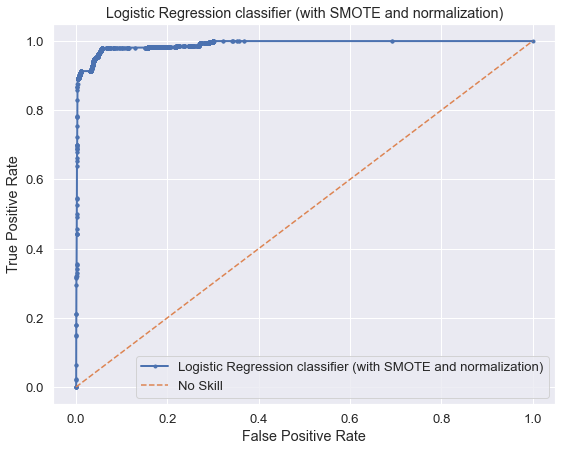

In [121]:
# predict probabilities
yhat = lr_sb_smote.predict_proba(X_test_scaled)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)

# plot model roc curve
plot_roc("Logistic Regression classifier (with SMOTE and normalization)")

In [122]:
predicted = lr_sb_smote.predict(X_test_scaled)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.92      0.81     13069
           1       1.00      0.98      0.99    240872

    accuracy                           0.98    253941
   macro avg       0.86      0.95      0.90    253941
weighted avg       0.98      0.98      0.98    253941



There is no  improvement after SMOTE and normalization from earlier (with class weight).Therefore, class weight should be good enough.

## RandomForest classifier

RandomForest is unaffected by the scale of numerical input variables, thus normalization/standardization not required.

In [123]:
rfc =RandomForestClassifier(verbose=2,n_estimators=5,max_depth=3,class_weight='balanced')

In [124]:
%%time

rfc.fit(X_train,y_train)

# get the prediction on the test data
predicted = rfc.predict(X_test)  # outlier labels (0 or 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
Wall time: 3.81 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


predict_proba() for Random Forest returns the number of votes for each class (each tree in the forest makes its own decision and chooses exactly one class), divided by the number of trees in the forest.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


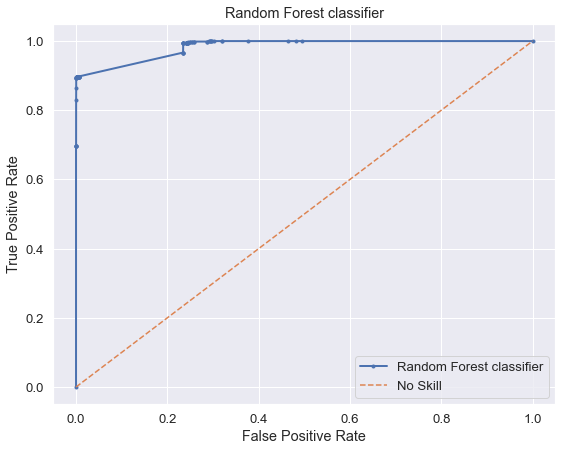

In [125]:
# predict probabilities
yhat = rfc.predict_proba(X_test)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)

# storing fpr,tpr and threshold for later
fpr_rfc, tpr_rfc, t_rfc = fpr, tpr, t 

# plot model roc curve
plot_roc("Random Forest classifier")

In [126]:
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.34      1.00      0.51     13069
           1       1.00      0.90      0.94    240872

    accuracy                           0.90    253941
   macro avg       0.67      0.95      0.73    253941
weighted avg       0.97      0.90      0.92    253941



RandomForest resulted in a comparitively good F1-score (0.79 for class 0 in comparison to 0.19 for LR) 

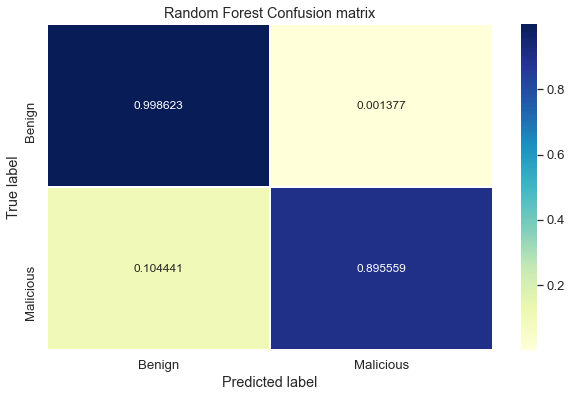

In [127]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predicted)
plot_confusion_matrix(matrix,title = 'Random Forest Confusion matrix')

In [128]:
feature_imp = pd.Series(rfc.feature_importances_,index=X.columns.tolist()).sort_values(ascending=False)

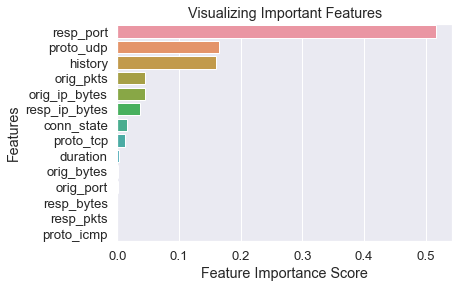

In [129]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## RandomForest classifier with Hyperparameter Tuning

In [100]:
rfc = RandomForestClassifier(random_state=2,class_weight='balanced')

In [101]:
param_grid = { 
    'n_estimators': [5,20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,20],
    'criterion' :['gini', 'entropy']
}

In [102]:
%%time
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=4,verbose=10)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 33min 7s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=2),
             n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [8, 20],
                         'n_estimators': [5, 20]},
             verbose=10)

In [106]:
CV_rfc.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 20}

In [109]:
predicted = CV_rfc.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    155918
           1       1.00      1.00      1.00   4213634

    accuracy                           1.00   4369552
   macro avg       1.00      1.00      1.00   4369552
weighted avg       1.00      1.00      1.00   4369552



### Using the best parameters from hyperparmeter tuning

In [119]:
rfc = RandomForestClassifier(verbose =2, 
                             random_state=2,
                             criterion= 'entropy', 
                             max_depth = 20, 
                             n_jobs = -1,
                             n_estimators = 20,
                             class_weight='balanced')

In [120]:
%%time

rfc.fit(X_train,y_train)

# get the prediction on the test data
predicted = rfc.predict(X_test)  # outlier labels (0 or 1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 20
building tree 2 of 20building tree 3 of 20building tree 4 of 20


building tree 5 of 20
building tree 6 of 20
building tree 7 of 20building tree 8 of 20

building tree 9 of 20building tree 10 of 20building tree 11 of 20
building tree 12 of 20


building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   36.3s remaining:   54.4s


building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   59.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 out of  20 | elapsed:    0.6s remaining:    0.9s


Wall time: 1min 4s


[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    1.0s finished


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 out of  20 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    1.1s finished


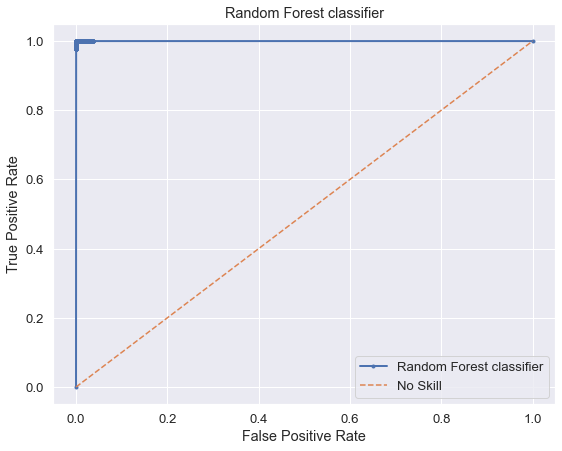

In [122]:
# predict probabilities
yhat = rfc.predict_proba(X_test)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)

# storing fpr,tpr and threshold for later
fpr_rfc, tpr_rfc, t_rfc = fpr, tpr, t 

# plot model roc curve
plot_roc("Random Forest classifier")

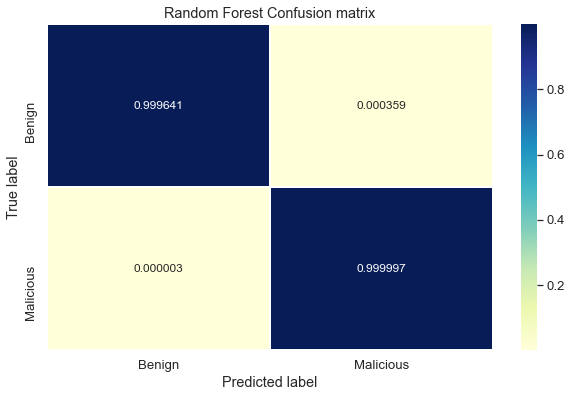

In [123]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predicted)
plot_confusion_matrix(matrix,title = 'Random Forest Confusion matrix')

In [128]:
feature_imp = pd.Series(rfc.feature_importances_,index=X.columns.tolist()).sort_values(ascending=False)

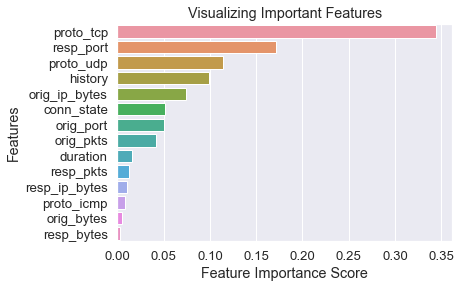

In [129]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Observations:
- Hyperparameter tuning on RandomForest resulted in the best F1-Score for both classes. 
- resp_pkts is observed high on Feature importance score for Logistic Regression, but low with RandomForest Classifier.
- history is of high importance for RandomForest

Learnings:
- If we don't have enough data, you we can try using k-fold cross validation, or else its not required.

## Naive Bayes classifier

- CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the complement of each class to compute the model’s weights. 
- Naive Bayes Machine Learning algorithm is NOT affected by feature magnitude, hence Naive Bayes does not need feature scaling.
- Naive Bayes is an eager learning classifier and it is much faster than K-NN. Thus, it could be used for prediction in real time. Typically, email spam filtering uses Naive Bayes classifier. The best part with this classifier is that, it learns over time. In a spam filtering task, the type of spam words in email evolves over time. In the same way, the classifier also calculates probability estimates for the newly occuring spam words in a "bag of words" model and makes sure it performs well. 

In [130]:
# Naive Bayes requires sample_weight for unbalanced classes. 

from sklearn.utils import class_weight
cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
sample_weight=[cw[i] for i in y_train]

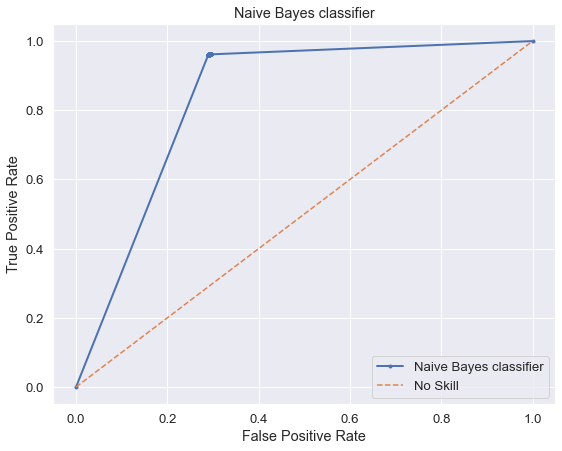

Wall time: 541 ms


In [131]:
%%time
from sklearn.naive_bayes import ComplementNB
cnbc = ComplementNB()
cnbc.fit(X_train,y_train)

# predict probabilities
yhat = cnbc.predict_proba(X_test)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, t = roc_curve(y_test, pos_probs)

# storing fpr,tpr and threshold for later
fpr_nb, tpr_nb, t_nb = fpr, tpr, t 

# plot model roc curve
plot_roc("Naive Bayes classifier")

In [132]:
predicted = cnbc.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.71      0.58     13069
           1       0.98      0.96      0.97    240872

    accuracy                           0.95    253941
   macro avg       0.74      0.84      0.78    253941
weighted avg       0.96      0.95      0.95    253941



Observations: 
- Very low F1 score for class 0 with Naive Bayes classifier
- High training speed

## Naive Bayes Classifier with hyperparameter tuning

In [133]:
%%time

params = {'alpha': [0.0001, 0.001,1.0], }

cnbc_grid = GridSearchCV(ComplementNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)

cnbc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 3.21 s


GridSearchCV(cv=5, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 1.0]}, verbose=5)

In [134]:
cnbc_grid.best_estimator_

ComplementNB(alpha=0.0001)

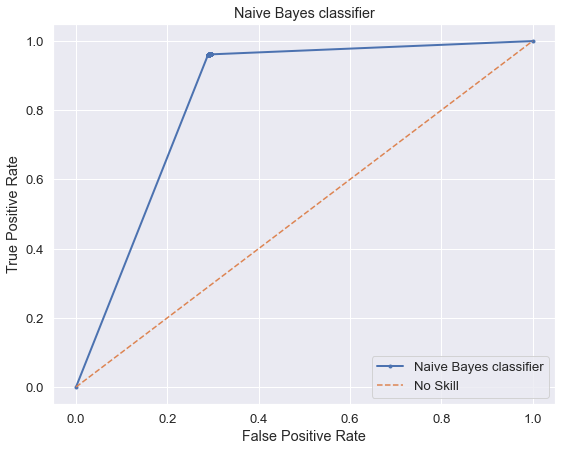

In [135]:
# predict probabilities
yhat = cnbc_grid.best_estimator_.predict_proba(X_test)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, t = roc_curve(y_test, pos_probs)

# storing fpr,tpr and threshold for later
fpr_nb, tpr_nb, t_nb = fpr, tpr, t 

# plot model roc curve
plot_roc("Naive Bayes classifier")

In [136]:
predicted = cnbc_grid.best_estimator_.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.71      0.58     13069
           1       0.98      0.96      0.97    240872

    accuracy                           0.95    253941
   macro avg       0.74      0.84      0.78    253941
weighted avg       0.96      0.95      0.95    253941



Observations:
- Hyperparameter tuning on alpha didn't affect the F1 Score.

## KNN classifier

- Unbalanced classes are not a problem at all for the k-nearest neighbor algorithm. Because the algorithm is not influenced in any way by the size of the class, it will not favor any on the basis of size. 
- KNN requires scaling of data because KNN uses the Euclidean distance between two data points to find nearest neighbors. Euclidean distance is sensitive to magnitudes. The features with high magnitudes will weight more than features with low magnitudes.

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

knc.fit(X_train_scaled,y_train)

In [ ]:
# predict probabilities
yhat = knc.predict_proba(X_test_scaled)

# retrieve the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, t = roc_curve(y_test, pos_probs)

fpr_knn, tpr_knn, t_knn = fpr, tpr, t 

plot_roc("ROC Curve KNNClassifier")

In [ ]:
predicted = knc.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

Observations:
- it took considerable time for KNN for fitting/training, so its better to use n_jobs=-1 to use all the cpu cores. Still it is too slow to use for this size of the data.

## SVM classifier

SVC fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets its better to consider using LinearSVC or SGDClassifier instead.  Also it is important to scale the data. predict_proba is only available for log loss and modified Huber loss.

In [ ]:
%%time
from sklearn.svm import SVC

svc = SVC(gamma='auto',probability=True)

svc.fit(X_train_scaled,y_train)

Observations:
- Resulted in MemoryError: Unable to allocate 22.8 GiB for an array with shape (10195620, 300) and data type float64 using LinearSVC and Nystroem.
- Support vector machine classifiers are non-probabilistic: they use a hyperplane (a line in 2D, a plane in 3D and so on) to separate points into one of two classes. This is in contrast with probabilistic classifiers like logistic regression and decision trees, which generate a probability for every point that is then converted to a prediction.

- CalibratedClassifierCV is a sort of meta-estimator; to use it, you simply pass your instance of a base estimator to its constructor, so this will work for calculating roc_curve:

base_model = SGDClassifier()
model = CalibratedClassifierCV(base_model)

model.fit(X, y)
model.predict_proba(X)

- Need to use cv='prefit' for the baseestimator to fit, and fit the baseestimator first.

## Neural Network classifier

The advantages of Multi-layer Perceptron are:

- Capability to learn non-linear models.

- Capability to learn models in real-time (on-line learning) using partial_fit.

The disadvantages of Multi-layer Perceptron (MLP) include:

- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.

- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.

- MLP is sensitive to feature scaling.

In [137]:
%%time

from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(solver='lbfgs',random_state=2, max_iter=20,hidden_layer_sizes=(5, 2),verbose=10)

mlpc.fit(X_train_scaled,y_train)

Wall time: 10.4 s


MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=20, random_state=2,
              solver='lbfgs', verbose=10)

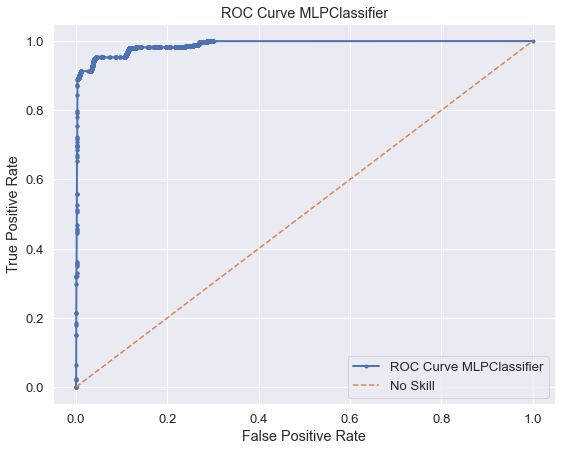

In [138]:
# predict probabilities
yhat = mlpc.predict_proba(X_test_scaled)

# retrieve the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, t = roc_curve(y_test, pos_probs)

fpr_mlpc, tpr_mlpc, t_mlpc = fpr, tpr, t 

plot_roc("ROC Curve MLPClassifier")

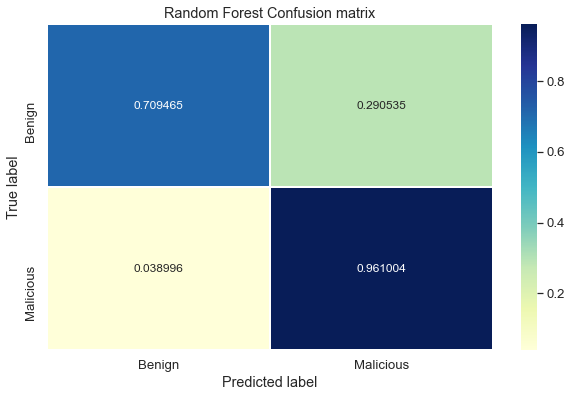

In [139]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predicted)
plot_confusion_matrix(matrix,title = 'Random Forest Confusion matrix')

In [140]:
predicted = mlpc.predict(X_test_scaled)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.70      0.82     13069
           1       0.98      1.00      0.99    240872

    accuracy                           0.98    253941
   macro avg       0.98      0.85      0.90    253941
weighted avg       0.98      0.98      0.98    253941



## Catboost classifier

In [141]:
from catboost import CatBoostClassifier, Pool

categorical_features_indices =  [0,1,5,6,11,12,13]
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

cb_params = {'iterations': 10,
          'eval_metric':'F1',
          "verbose": 5}

In [142]:
%%time
cbc = CatBoostClassifier(**cb_params)

cbc.fit(train_pool, eval_set=validate_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 0.9927830	test: 0.9927805	best: 0.9927805 (0)	total: 414ms	remaining: 3.72s
5:	learn: 0.9993991	test: 0.9994274	best: 0.9994394 (4)	total: 1.82s	remaining: 1.22s
9:	learn: 0.9997927	test: 0.9997841	best: 0.9997841 (9)	total: 2.67s	remaining: 0us

bestTest = 0.9997841123
bestIteration = 9

Wall time: 5.03 s


In [143]:
cbc.get_best_score()

{'learn': {'Logloss': 0.004535272836390964, 'F1': 0.9997926882521699},
 'validation': {'Logloss': 0.004480599098651403, 'F1': 0.9997841123280164}}

In [144]:
predicted = cbc.predict(data=X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13069
           1       1.00      1.00      1.00    240872

    accuracy                           1.00    253941
   macro avg       1.00      1.00      1.00    253941
weighted avg       1.00      1.00      1.00    253941



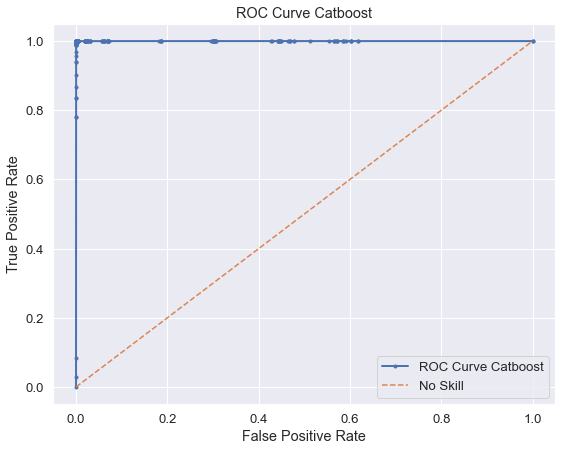

In [145]:
# predict probabilities
yhat = cbc.predict_proba(X_test)

# retrieve the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, t = roc_curve(y_test, pos_probs)

fpr_cbc, tpr_cbc, t_cbc = fpr, tpr, t 

plot_roc("ROC Curve Catboost")

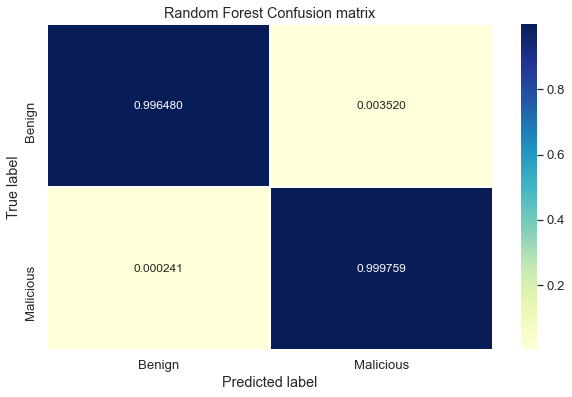

In [146]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, predicted)
plot_confusion_matrix(matrix,title = 'Random Forest Confusion matrix')

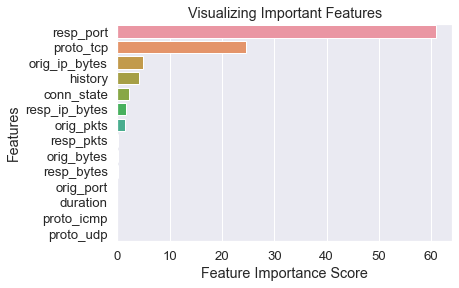

In [147]:
feature_imp = pd.Series(cbc.feature_importances_,index=X.columns.tolist()).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Votingclassifier (Majority Class Labels (Majority/Hard Voting))

E.g., if the prediction for a given sample is

classifier 1 -> class 1

classifier 2 -> class 1

classifier 3 -> class 2

the VotingClassifier (with voting='hard') would classify the sample as “class 1” based on the majority class label.

In [148]:
%%time
from sklearn.ensemble import VotingClassifier

# Using the best performing classifiers
clf1 = LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=2)
clf2 = RandomForestClassifier(n_estimators=20,max_depth=20,class_weight='balanced',random_state=2) 
clf3 = MLPClassifier(solver='lbfgs',random_state=2, max_iter=30,hidden_layer_sizes=(5, 2))
clf4 = CatBoostClassifier(**cb_params)

vc_hard = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('mlp', clf3), ('cat', clf4)],
    voting='hard')

vc_hard.fit(X_train_scaled,y_train)

Learning rate set to 0.5
0:	learn: 0.9963059	total: 98.4ms	remaining: 885ms
5:	learn: 0.9987620	total: 580ms	remaining: 387ms
9:	learn: 0.9992517	total: 965ms	remaining: 0us
Wall time: 1min 8s


VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=2)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20,
                                                     n_estimators=20,
                                                     random_state=2)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(5, 2),
                                            max_iter=30, random_state=2,
                                            solver='lbfgs')),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000001AD5B2DF4F0>)])

In [149]:
predicted = vc_hard.predict(X_test_scaled)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     13069
           1       1.00      1.00      1.00    240872

    accuracy                           1.00    253941
   macro avg       0.98      0.99      0.98    253941
weighted avg       1.00      1.00      1.00    253941



## Votingclassifier (Weighted Average Probabilities (Soft Voting))

let’s assume we have 3 classifiers and a 3-class classification problems where we assign equal weights to all classifiers: w1=1, w2=1, w3=1.

The weighted average probabilities for a sample would then be calculated as follows:
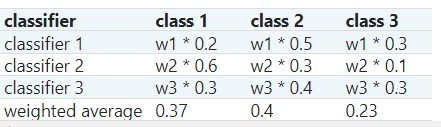
Here, the predicted class label is 2, since it has the highest average probability.

In [150]:
%%time
# Using the best performing classifiers
clf1 = LogisticRegression(solver='lbfgs',class_weight='balanced',random_state=2)
clf2 = RandomForestClassifier(n_estimators=20,max_depth=20,class_weight='balanced',random_state=2) 
clf3 = MLPClassifier(solver='lbfgs',random_state=2, max_iter=30,hidden_layer_sizes=(5, 2))
clf4 = CatBoostClassifier(**cb_params)

vc_soft = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('mlp', clf3), ('cat', clf4)],
    voting='soft')

vc_soft.fit(X_train_scaled,y_train)

Learning rate set to 0.5
0:	learn: 0.9963059	total: 96.9ms	remaining: 872ms
5:	learn: 0.9987620	total: 574ms	remaining: 383ms
9:	learn: 0.9992517	total: 975ms	remaining: 0us
Wall time: 1min 8s


VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=2)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20,
                                                     n_estimators=20,
                                                     random_state=2)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(5, 2),
                                            max_iter=30, random_state=2,
                                            solver='lbfgs')),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000001AD339323D0>)],
                 voting='soft')

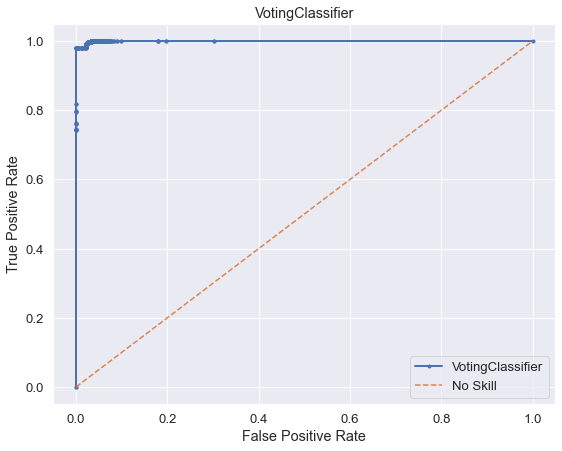

In [151]:
# predict probabilities
yhat = vc_soft.predict_proba(X_test_scaled)

# retrieve the probabilities for the positive class
pos_probs = yhat[:, 1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)

plot_roc("VotingClassifier")

In [152]:
predicted = vc_soft.predict(X_test_scaled)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13069
           1       1.00      1.00      1.00    240872

    accuracy                           1.00    253941
   macro avg       0.99      0.98      0.98    253941
weighted avg       1.00      1.00      1.00    253941



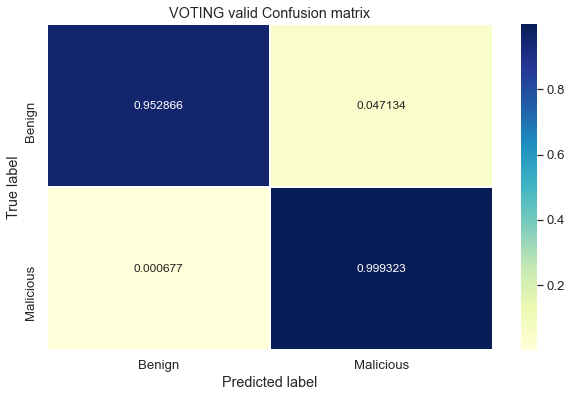

In [153]:
# Confusion maxtrix
matrix = confusion_matrix(y_test, predicted)
plot_confusion_matrix(matrix,title = 'VOTING valid Confusion matrix')

In [154]:
# save the model to disk
import pickle
filename = 'finalized_model-2.sav'
pickle.dump(vc_soft, open(filename, 'wb'))